# Results Exploration

In [1]:
import sys
sys.path.append('./../src/')

import os
import re
import ast
import utils
import ioutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from feature_selection import _feature_importance_permutation

from sklearn.metrics import roc_auc_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def prep_selector_labels(labels):
    
    outputs = []
    for label in labels:
        splitted = label.split('_')
        
        if 'var' in splitted:
            outputs.append('Variance Threshold')
        if 'mutual' in splitted:
            for num, item in enumerate(splitted):
                splitted[num] = item.capitalize()
            outputs.append((' ').join(splitted))
        if 'relieff' in splitted:
            for num, item in enumerate(splitted):
                splitted[num] = item[:-1].capitalize() + item[-1].capitalize()
            outputs.append(('').join(splitted))
        if 'logregl1' in splitted:
            outputs.append('{}:\n{}'.format('Permutation Importance', 'Logistic Regression L1'))
        if 'logregl2' in splitted:
            outputs.append('{}:\n{}'.format('Permutation Importance', 'Logistic Regression L2'))
        if 'rf' in splitted:
            outputs.append('{}:\n{}'.format('Permutation Importance', 'Random Forest'))
            
    return outputs

In [3]:
def prep_feature_names(labels, image_type='squareroot'):
    
    outputs = []
    for label in labels:
        if image_type in label:
            
            if 'firstorder' in label:
                modality, _, kind, name = label.split('_')
                outputs.append('{} {}:\n{}'.format(
                    modality.upper(), kind.capitalize(), name)
                )
            else:
                modality, _, kind, name = label.split('_')
                outputs.append('{} {}:\n{}'.format(modality.upper(), kind.upper(), name))
        # Clinical variables.
        else:
            if 'hpv_1' in label:
                outputs.append('Recieved HPV')
            if 'hpv_2' in label:
                outputs.append('Missing HPV information')
            if 'peak' in label:
                outputs.append('SUV Peak')
            if 'mtv' in label:
                outputs.append(label.upper())
            if 't_class_3' in label:
                outputs.append('T-class 3')
            if 'stage_1' in label:
                outputs.append('Stage 1')
            if 'stage_3' in label:
                outputs.append('Stage 3')
            if 'icd10_C32' in label:
                outputs.append('ICD-10: C32')
            if 'cisplatin_6' in label:
                outputs.append('Cisplatin: 6')
                
    return outputs

In [4]:
X = pd.read_csv(
    './../../data/fallback/data_to_analysis/data.csv', index_col=0
)
y_pfs = pd.read_csv(
    './../../data/fallback/data_to_analysis/target_pfs.csv', index_col=0
)
y_lrc = pd.read_csv(
    './../../data/fallback/data_to_analysis/target_lrc.csv', index_col=0
)

In [5]:
X.shape

(198, 87)

## PFS

In [6]:
pfs_results_raw = pd.read_csv(
    './../../data/fallback/results/results_pfs.csv', index_col=0
)
pfs_results_raw.head()

,experiment_id,model,selector,best_params,avg_test_score,avg_train_score,best_features,num_features
0,684,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.567981,0.567981,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,86
1,559,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.535718,0.535718,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,85
2,629,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.542366,0.542366,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,86
3,192,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.544179,0.544179,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,86
4,835,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.553236,0.553236,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,86


In [7]:
model_names = []

avg_pfs_results = np.zeros((6, 6), dtype=float)
std_pfs_results = np.zeros((6, 6), dtype=float)
for row_num, (model_name, model_grp) in enumerate(pfs_results_raw.groupby('model')):
    model_names.append(model_name)
    for col_num, (selector_name, selector_grp) in enumerate(model_grp.groupby('selector')):
        avg_pfs_results[row_num, col_num] = selector_grp['avg_test_score'].mean()
        std_pfs_results[row_num, col_num] = selector_grp['avg_test_score'].std()

In [8]:
selector_names = prep_selector_labels(pfs_results_raw.selector.unique())

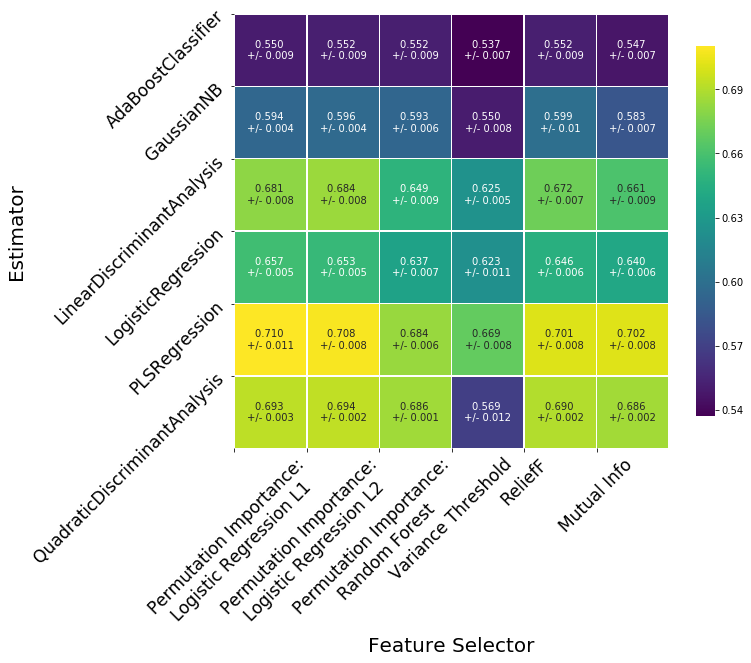

In [85]:
plt.figure(figsize=(11, 11))
axis = sns.heatmap(
    avg_pfs_results, 
    vmin=np.nanmin(avg_pfs_results), vmax=np.nanmax(avg_pfs_results),
    cmap=plt.cm.viridis, robust=True,
    annot=True, fmt = '.3f', square=1, linewidth=.5, cbar=True,
    cbar_kws={'shrink': 0.6},  
)
plt.ylabel('Estimator', fontsize=20)
plt.xlabel('Feature Selector', fontsize=20)
plt.xticks(
    range(np.size(selector_names)), selector_names, 
    rotation='45', fontsize=17, x='right', va='top', 
)
plt.yticks(
    range(np.size(model_names)), model_names, 
    rotation='45', fontsize=17, y=-0.5
)
for num, value in enumerate(axis.texts): 
    value.set_text('{} \n+/- {}'.format(
        value.get_text(), 
        np.round(std_pfs_results.ravel()[num], decimals=3),
        fontsize=16
    )
)
plt.tight_layout()   
plt.savefig(
    './../../data/fallback/figures/pfs_matrix.png', 
    transparent=True, dpi=400
)

In [10]:
plsr_pfs_features = []
for model_name, model_data in pfs_results_raw.groupby('model'):
    if 'PL' in model_name:
        for sel_name, model_sel_data in model_data.groupby('selector'):
            if 'logregl1' in sel_name:
                plsr_pfs_features.extend(model_sel_data['best_features'].values)
                print(model_sel_data['best_params'].values)

["{'copy': True, 'max_iter': 500, 'n_components': 70, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 71, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 72, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 75, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 71, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 75, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 70, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 70, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 76, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 69, 'scale': True, 'tol': 0.001}"]


In [11]:
# Retain features selected across all experiments.
plsr_pfs_votings = np.zeros(X.columns.size, dtype=int)
for feature_set in plsr_pfs_features:
    prep_features = []
    for feature in feature_set.split():
        if feature.isdigit():
            plsr_pfs_votings[int(feature)] += 1

In [12]:
sum(plsr_pfs_votings == 10)

83

In [13]:
plsr_pfs_feature_counts = {
    'shape': 0, 
    'firstorder': 0, 
    'glcm': 0, 
    'glrlm': 0, 
    'glszm': 0, 
    'gldm': 0, 
    'ngtdm': 0
}
for vote, label in zip(plsr_pfs_votings, X.columns):
    if vote > 0:
        for key in plsr_pfs_feature_counts:
            if key in label:
                plsr_pfs_feature_counts[key] += 1
                
orig_num_features = {
    'shape': 0, 
    'firstorder': 0, 
    'glcm': 0, 
    'glrlm': 0, 
    'glszm': 0, 
    'gldm': 0, 
    'ngtdm': 0
}
for key in orig_num_features:
    for feature in X.columns:
        if key in feature:
            orig_num_features[key] += 1

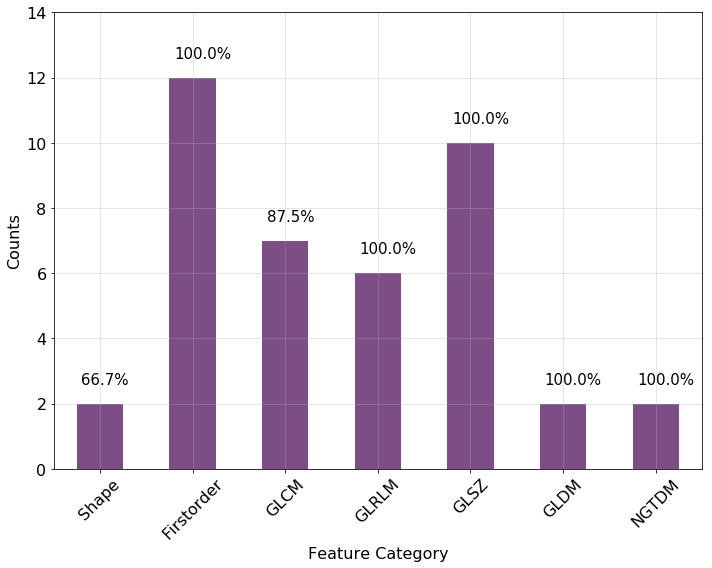

In [14]:
tick_labels = [
    'Shape', 'Firstorder', 'GLCM', 'GLRLM', 'GLSZ', 'GLDM', 'NGTDM'
]
fig = pd.Series(plsr_pfs_feature_counts).plot(
    figsize=(10, 8),
    kind='bar',
    fontsize=16,
    colormap=plt.cm.viridis,
    rot=45,
    alpha=0.7,
)
fig.patch.set_visible(True)

for num, (label, value) in enumerate(orig_num_features.items()):
    recovery = plsr_pfs_feature_counts[label] / orig_num_features[label]
    plt.text(
        x=num - 0.2,
        y=plsr_pfs_feature_counts[label] + 0.6,
        s='{}%'.format(np.round(recovery * 100, decimals=1)),
        fontsize=15
    )
plt.ylim([0, 14])
plt.ylabel('Counts', fontsize=16)
plt.xlabel('Feature Category', fontsize=16)
plt.xticks(np.arange(len(tick_labels)), tick_labels)
plt.grid(which='both', alpha=0.4)
plt.tight_layout()
plt.savefig('./../../data/fallback/figures/feature_counts')

In [15]:
pfs_feature_importances = []

X_data, y_data = X[X.columns[plsr_pfs_votings == 10]].values, y_pfs.values
for seed in range(10):
    sampler = utils.BootstrapOutOfBag(n_splits=50, random_state=seed)
    for train_idx, test_idx in sampler.split(X_data, y_data):
        
        X_train, X_test = X_data[train_idx], X_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        
        X_train_std, X_test_std = utils.train_test_z_scores(X_train, X_test)

        model = PLSRegression(n_components=70, max_iter=500, scale=True, tol=0.001)
        model.fit(X_train_std, y_train)

        imps = _feature_importance_permutation(
            X_test_std, y_test, model, score_func=roc_auc_score, 
            num_rounds=10, seed=seed
        )
        pfs_feature_importances.append(imps)

In [16]:
np.shape(np.mean(pfs_feature_importances, axis=0)), sum(plsr_pfs_votings == 10)

((83,), 83)

In [17]:
avg_pfs_importances = np.mean(pfs_feature_importances, axis=0)

In [18]:
pfs_contributors = np.copy(avg_pfs_importances)
pfs_removeables = np.copy(avg_pfs_importances)
pfs_contributors[avg_pfs_importances < 0] = 0
pfs_removeables[avg_pfs_importances > 0] = 0

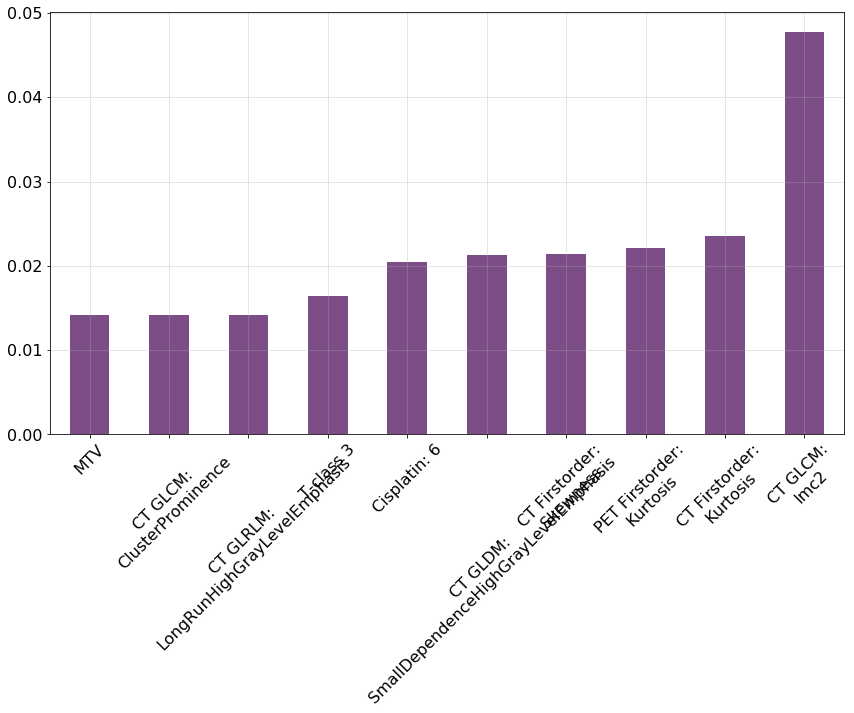

In [83]:
top_idx = np.argsort(pfs_contributors)[-10:]
pd.Series(pfs_contributors[top_idx]).plot(
    kind='bar',
    figsize=(12, 10), 
    fontsize=16,
    colormap=plt.cm.viridis,
    alpha=0.7,
);
plt.xticks(
    range(np.size(top_idx)), prep_feature_names(X.columns[top_idx]),
    rotation=45
);
plt.yticks(fontsize=16);
plt.grid(which='both', alpha=0.4)
plt.tight_layout()
plt.savefig('./../../data/fallback/figures/plsr_feature_rankings.png')

# LRC

In [23]:
lrc_results_raw = pd.read_csv(
    './../../data/fallback/results/results_lrc.csv', index_col=0
)
lrc_results_raw.head()

,avg_test_score,avg_train_score,best_features,best_params,experiment_id,model,num_features,selector
0,0.520569,0.520569,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",684,AdaBoostClassifier,86,logregl1_permut_imp
1,0.533694,0.533694,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",559,AdaBoostClassifier,86,logregl1_permut_imp
2,0.537017,0.537017,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",629,AdaBoostClassifier,86,logregl1_permut_imp
3,0.545093,0.545093,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",192,AdaBoostClassifier,86,logregl1_permut_imp
4,0.534762,0.534762,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",835,AdaBoostClassifier,86,logregl1_permut_imp


In [24]:
model_names = []

avg_lrc_results = np.zeros((6, 6), dtype=float)
std_lrc_results = np.zeros((6, 6), dtype=float)
for row_num, (model_name, model_grp) in enumerate(lrc_results_raw.groupby('model')):
    model_names.append(model_name)
    for col_num, (selector_name, selector_grp) in enumerate(model_grp.groupby('selector')):
        avg_lrc_results[row_num, col_num] = selector_grp['avg_test_score'].mean()
        std_lrc_results[row_num, col_num] = selector_grp['avg_test_score'].std()

In [25]:
selector_names = prep_selector_labels(lrc_results_raw.selector.unique())

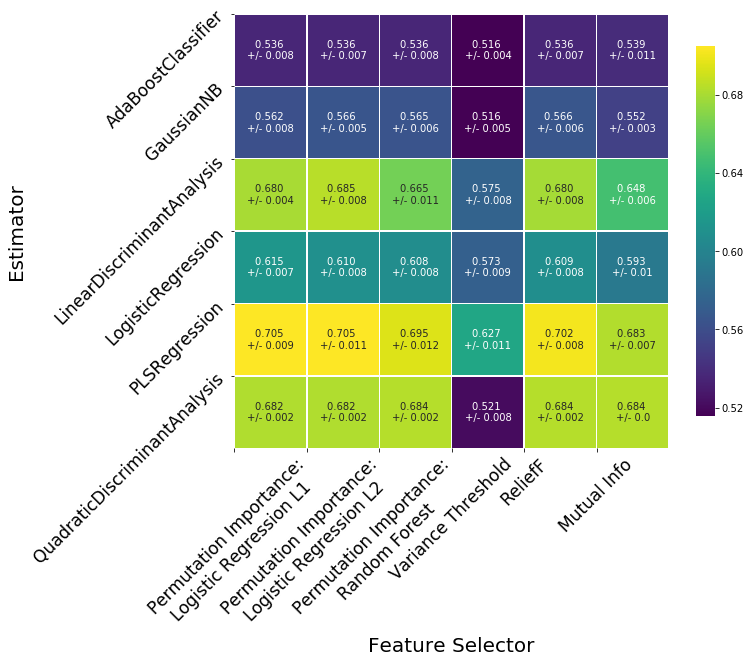

In [87]:
plt.figure(figsize=(11, 11))
axis = sns.heatmap(
    avg_lrc_results, 
    vmin=np.nanmin(avg_lrc_results), vmax=np.nanmax(avg_lrc_results),
    cmap=plt.cm.viridis, robust=True,
    annot=True, fmt = '.3f', square=1, linewidth=.5, cbar=True,
    cbar_kws={'shrink': 0.6},  
)
plt.ylabel('Estimator', fontsize=20)
plt.xlabel('Feature Selector', fontsize=20)
plt.xticks(
    range(np.size(selector_names)), selector_names, 
    rotation='45', fontsize=17, x='right', va='top', 
)
plt.yticks(
    range(np.size(model_names)), model_names, 
    rotation='45', fontsize=17, y=-0.5
)
for num, value in enumerate(axis.texts): 
    value.set_text('{} \n+/- {}'.format(
        value.get_text(), 
        np.round(std_lrc_results.ravel()[num], decimals=3),
        fontsize=16
    )
)
plt.tight_layout()   
plt.savefig(
    './../../data/fallback/figures/lrc_matrix.png', 
    transparent=True, dpi=400
)

In [27]:
plsr_lrc_features = []
for model_name, model_data in lrc_results_raw.groupby('model'):
    if 'PL' in model_name:
        for sel_name, model_sel_data in model_data.groupby('selector'):
            if 'logregl1' in sel_name:
                plsr_lrc_features.extend(model_sel_data['best_features'].values)
                print(model_sel_data['best_params'].values)

["{'copy': True, 'max_iter': 500, 'n_components': 70, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 72, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 71, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 69, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 69, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 67, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 69, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 68, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 68, 'scale': True, 'tol': 0.001}"
 "{'copy': True, 'max_iter': 500, 'n_components': 68, 'scale': True, 'tol': 0.001}"]


In [28]:
# Retain features selected across all experiments.
plsr_lrc_votings = np.zeros(X.columns.size, dtype=int)
for feature_set in plsr_lrc_features:
    prep_features = []
    for feature in feature_set.split():
        if feature.isdigit():
            prep_features.append(int(feature))
            plsr_lrc_votings[int(feature)] += 1

In [29]:
sum(plsr_lrc_votings == 10)

84

In [30]:
plsr_lrc_feature_counts = {
    'shape': 0, 
    'firstorder': 0, 
    'glcm': 0, 
    'glrlm': 0, 
    'glszm': 0, 
    'gldm': 0, 
    'ngtdm': 0
}
for vote, label in zip(plsr_lrc_votings, X.columns):
    if vote > 0:
        for key in plsr_lrc_feature_counts:
            if key in label:
                plsr_lrc_feature_counts[key] += 1    
orig_num_features = {
    'shape': 0, 
    'firstorder': 0, 
    'glcm': 0, 
    'glrlm': 0, 
    'glszm': 0, 
    'gldm': 0, 
    'ngtdm': 0
}
for key in orig_num_features:
    for feature in X.columns:
        if key in feature:
            orig_num_features[key] += 1

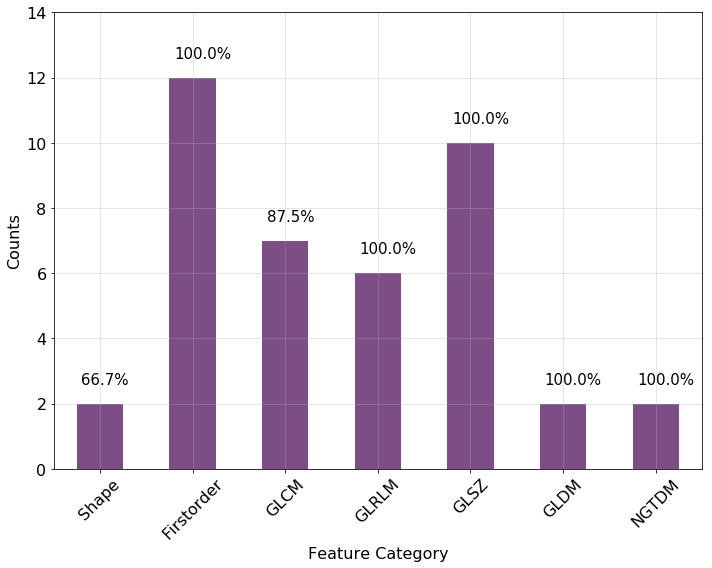

In [31]:
tick_labels = [
    'Shape', 'Firstorder', 'GLCM', 'GLRLM', 'GLSZ', 'GLDM', 'NGTDM'
]
fig = pd.Series(plsr_lrc_feature_counts).plot(
    figsize=(10, 8),
    kind='bar',
    fontsize=16,
    colormap=plt.cm.viridis,
    rot=45,
    alpha=0.7,
)
fig.patch.set_visible(True)

for num, (label, value) in enumerate(orig_num_features.items()):
    recovery = plsr_lrc_feature_counts[label] / orig_num_features[label]
    plt.text(
        x=num - 0.2,
        y=plsr_lrc_feature_counts[label] + 0.6,
        s='{}%'.format(np.round(recovery * 100, decimals=1)),
        fontsize=15
    )
plt.ylim([0, 14])
plt.ylabel('Counts', fontsize=16)
plt.xlabel('Feature Category', fontsize=16)
plt.xticks(np.arange(len(tick_labels)), tick_labels)
plt.grid(which='both', alpha=0.4)
plt.tight_layout()
plt.savefig('./../../data/fallback/figures/feature_counts2')

In [32]:
lrc_feature_importances = []

X_data, y_data = X[X.columns[plsr_lrc_votings == 10]].values, y_lrc.values
for seed in range(10):
    sampler = utils.BootstrapOutOfBag(n_splits=50, random_state=seed)
    for train_idx, test_idx in sampler.split(X_data, y_data):
        
        X_train, X_test = X_data[train_idx], X_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        
        X_train_std, X_test_std = utils.train_test_z_scores(X_train, X_test)

        model = PLSRegression(n_components=70, max_iter=500, scale=True, tol=0.001)
        model.fit(X_train_std, y_train)

        imps = _feature_importance_permutation(
            X_test_std, y_test, model, score_func=roc_auc_score, 
            num_rounds=10, seed=seed
        )
        lrc_feature_importances.append(imps)

In [33]:
np.shape(np.mean(lrc_feature_importances, axis=0))

(84,)

In [34]:
avg_lrc_importances = np.mean(lrc_feature_importances, axis=0)

In [35]:
lrc_contributors = np.copy(avg_lrc_importances)
lrc_removeables = np.copy(avg_lrc_importances)
lrc_contributors[avg_lrc_importances < 0] = 0
lrc_removeables[avg_lrc_importances >= 0] = 0

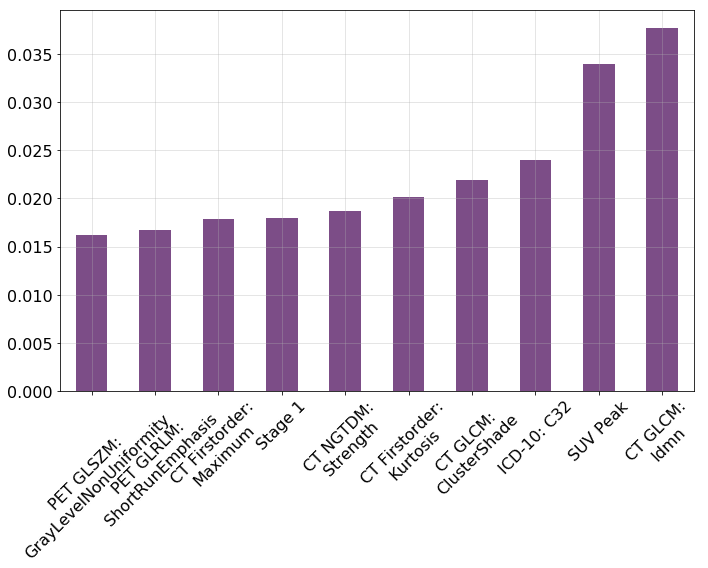

In [84]:
top_idx = np.argsort(lrc_contributors)[-10:]
pd.Series(lrc_contributors[top_idx]).plot(
    kind='bar',
    figsize=(10, 8), 
    fontsize=16,
    colormap=plt.cm.viridis,
    alpha=0.7,
);
plt.xticks(
    range(np.size(top_idx)), prep_feature_names(X.columns[top_idx]),
    rotation=45
);
plt.yticks(fontsize=16);
plt.grid(which='both', alpha=0.4)
plt.tight_layout()
plt.savefig('./../../data/fallback/figures/plsr_feature_rankings2.png')

In [41]:
X.columns[plsr_lrc_votings == 10]

Index(['age', 'year_smoking', 'days_naxogin', 'sex_M', 'icd10_C02',
       'icd10_C03', 'icd10_C04', 'icd10_C05', 'icd10_C06', 'icd10_C09',
       'icd10_C10', 'icd10_C12', 'icd10_C13', 'icd10_C32', 't_class_2',
       't_class_3', 't_class_4', 'n_class_1', 'n_class_2', 'n_class_3',
       'histology_1.0', 'histology_2.0', 'histology_3.0', 'hpv_1', 'hpv_2',
       'ecog_1', 'ecog_2', 'charlson_1', 'charlson_2', 'charlson_3',
       'charlson_4', 'cisplatin_1', 'cisplatin_2', 'cisplatin_3',
       'cisplatin_4', 'cisplatin_5', 'cisplatin_6', 'stage_1', 'stage_2',
       'stage_3', 'stage_4', 'suv_peak', 'mtv',
       'pet_squareroot_firstorder_Minimum',
       'pet_squareroot_firstorder_10Percentile',
       'pet_squareroot_firstorder_Skewness',
       'pet_squareroot_firstorder_Kurtosis',
       'pet_squareroot_glrlm_ShortRunEmphasis',
       'pet_squareroot_glrlm_LongRunEmphasis',
       'pet_squareroot_glrlm_RunLengthNonUniformityNormalized',
       'pet_squareroot_glszm_SmallAreaEmp

In [57]:
matches = 0
for lrc_feature in (X.columns[plsr_lrc_votings == 10]):
    if lrc_feature in X.columns[plsr_pfs_votings == 10]:
        matches += 1
    else:
        print(lrc_feature)
matches

histology_3.0


83

In [53]:
sum(plsr_pfs_votings == 10), sum(plsr_lrc_votings == 10)

(83, 84)

In [73]:
1 - sum(y_pfs.values == 1) / np.size(y_pfs.values)

array([0.67676768])

In [74]:
1- sum(y_lrc.values == 1) / np.size(y_lrc.values)

array([0.75252525])